In [35]:
import pandas as pd
import nfl_data_py as nfl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from pulp import *
import gurobipy as gp
import requests
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
import numpy as np


In [37]:
# NFL-Spielplan 2019
date = nfl.import_schedules([2019])
clean_date = date[['game_id', 'week', 'home_team', 'away_team' , 'home_score', 'away_score']]

In [38]:
# NFL-Spieplan
date_1 = nfl.import_schedules([2018])
clean_date_1 = date_1[['game_id', 'week', 'home_team', 'away_team' , 'home_score', 'away_score']]

In [4]:
# Laden der wöchentlichen Daten der Spieler
df_2020 = nfl.import_weekly_data([2020], downcast=True)
df_2020 = df_2020.loc[df_2020['season_type'] == "REG"]
df_2019 = nfl.import_weekly_data([2019], downcast=True)
df_2019 = df_2019.loc[df_2019['season_type'] == "REG"]
df_2018 = nfl.import_weekly_data([2018], downcast=True)
df_2018 = df_2018.loc[df_2018['season_type'] == "REG"]
df_2017 = nfl.import_weekly_data([2017], downcast=True)
df_2017 = df_2017.loc[df_2017['season_type'] == "REG"]

Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.


In [39]:
# Laden der Rosters
roster = nfl.import_rosters([2019])

In [40]:
# Laden Kicker-Daten von 2019

url = "https://www.fantasypros.com/nfl/reports/leaders/k.php?year=2019"

response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')


table = soup.find('table')

df_kicker = pd.read_html(str(table))[0]
df_kicker = df_kicker.merge(roster[['player_name', 'player_id', 'team']], left_on='Player', right_on='player_name', how='left')
df_kicker = df_kicker.drop(['Team', 'player_name', '#'], axis=1)

df_kicker = df_kicker.rename(columns={'team' : 'Team'})

df_kicker.set_index(['Player', 'Pos', 'Team', 'AVG', 'TTL', 'player_id'], inplace=True)
# in ein Longformat bringen für spätere Verwendung 
df_long_k = df_kicker.reset_index().melt(id_vars=['Player', 'Pos', 'Team', 'AVG', 'TTL', 'player_id'], var_name='Week', value_name='Points')


df_long_k.sort_values(['Player', 'Week'], inplace=True)


df_long_k.reset_index(drop=True, inplace=True) 

In [41]:
# das gleiche für die Defenses
url = "https://www.fantasypros.com/nfl/reports/leaders/dst.php?year=2019"

response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table')

df_defense = pd.read_html(str(table))[0]
# es muss eine eigene player_id für die Defenses erstellt werden
df_defense['player_id'] = [(str(i // 1000).zfill(2) + '-' + str(i % 1000).zfill(6)) for i in range(1, len(df_defense) + 1)]

df_defense = df_defense.drop(['#'], axis=1)

df_defense.set_index([ 'Player', 'Pos', 'Team', 'AVG', 'TTL','player_id'], inplace=True)

df_long = df_defense.reset_index().melt(id_vars=['Player', 'Pos', 'Team', 'AVG', 'TTL', 'player_id'], var_name='Week', value_name='Points')

df_long.sort_values(['Player', 'Week'], inplace=True)

df_long.reset_index(drop=True, inplace=True)



In [42]:


# Jetzt können wir die dfs der Kicker und der Defenses zusammenführen und zu dem gesamten df von 2019 hinzufügen
df_long_combined = pd.concat([df_long_k, df_long], axis=0, ignore_index=True, sort=False)

df_long_combined = df_long_combined.rename(columns={'Team' : 'recent_team', 'Pos' : 'position_group', 'Points': 'fantasy_points_ppr', 'Week' : 'week', 'Player' : 'player_display_name'})

df_long_combined['week'] = df_long_combined['week'].astype('int32')
df_long_combined['fantasy_points_ppr'] = df_long_combined['fantasy_points_ppr'].replace(['-', 'BYE'], 0).astype('float32')
df_long_combined['recent_team'] = df_long_combined['recent_team'].replace({'JAC': 'JAX', 'LAR': 'LA'})

df_2019_complete = pd.concat([df_2019, df_long_combined], axis=0, ignore_index=True, sort=False)



In [43]:
# Das Gleiche mit den Daten von den Kickern von 2018

url = "https://www.fantasypros.com/nfl/reports/leaders/k.php?year=2018"

response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table')

df_kicker_1 = pd.read_html(str(table))[0]
df_kicker_1 = df_kicker_1.merge(roster[['player_name', 'player_id', 'team']], left_on='Player', right_on='player_name', how='left')
df_kicker_1 = df_kicker_1.drop(['Team', 'player_name', '#'], axis=1)

df_kicker_1 = df_kicker_1.rename(columns={'team' : 'Team'})

df_kicker_1.set_index(['Player', 'Pos', 'Team', 'AVG', 'TTL', 'player_id'], inplace=True)

df_long_k_1 = df_kicker_1.reset_index().melt(id_vars=['Player', 'Pos', 'Team', 'AVG', 'TTL', 'player_id'], var_name='Week', value_name='Points')

df_long_k_1.sort_values(['Player', 'Week'], inplace=True)

df_long_k_1.reset_index(drop=True, inplace=True) 

In [44]:
# das Gleiche mit den Defenses von 2018
url = "https://www.fantasypros.com/nfl/reports/leaders/dst.php?year=2019"

response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table')

df_defense = pd.read_html(str(table))[0]

df_defense['player_id'] = [(str(i // 1000).zfill(2) + '-' + str(i % 1000).zfill(6)) for i in range(1, len(df_defense) + 1)]

df_defense = df_defense.drop(['#'], axis=1)

df_defense.set_index([ 'Player', 'Pos', 'Team', 'AVG', 'TTL','player_id'], inplace=True)

df_long_1 = df_defense.reset_index().melt(id_vars=['Player', 'Pos', 'Team', 'AVG', 'TTL', 'player_id'], var_name='Week', value_name='Points')

df_long_1.sort_values(['Player', 'Week'], inplace=True)

df_long_1.reset_index(drop=True, inplace=True)



In [45]:


# Jetzt können wir die dfs wieder zusammenführen und zu dem gesamten df von 2018 hinzufügen
df_long_combined_1 = pd.concat([df_long_k_1, df_long_1], axis=0, ignore_index=True, sort=False)

df_long_combined_1 = df_long_combined_1.rename(columns={'Team' : 'recent_team', 'Pos' : 'position_group', 'Points': 'fantasy_points_ppr', 'Week' : 'week', 'Player' : 'player_display_name'})

df_long_combined_1['week'] = df_long_combined_1['week'].astype('int32')
df_long_combined_1['fantasy_points_ppr'] = df_long_combined_1['fantasy_points_ppr'].replace(['-', 'BYE'], 0).astype('float32')
df_long_combined_1['recent_team'] = df_long_combined_1['recent_team'].replace({'JAC': 'JAX', 'LAR': 'LA'})

df_2018_complete = pd.concat([df_2018, df_long_combined_1], axis=0, ignore_index=True, sort=False)



In [46]:
# wir behalten nur relevante Positionen und Spalten
new_test = df_2019_complete[['player_id', 'player_display_name', 'position_group', 'recent_team', 'season', 'week', 'fantasy_points', 'fantasy_points_ppr']]
players = new_test
games = clean_date
players['recent_team'] = players['recent_team'].replace('LV', 'OAK')
positions = ['QB', 'TE', 'WR', 'RB', 'K', 'DST']
players_clean = players[players['position_group'].isin(positions)]


/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_1153/956684513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['recent_team'] = players['recent_team'].replace('LV', 'OAK')


In [47]:
# wir errechnen die durchschnittlichen zugelassenen Punkte jedes Teams gegen die jeweilige Position
players_home = players_clean.merge(games, left_on=['recent_team', 'week'], right_on=['home_team', 'week'], how='left')


players_away = players_clean.merge(games, left_on=['recent_team', 'week'], right_on=['away_team', 'week'], how='left')


players_copy = players_clean.copy()
players_home = players_home.reset_index(drop=True)
players_away = players_away.reset_index(drop=True)
players_copy = players_copy.reset_index(drop=True)


players_copy.loc[:, 'opponent'] = players_home['away_team']
nan_rows = players_copy['opponent'].isna()
players_copy.loc[nan_rows, 'opponent'] = players_away.loc[nan_rows, 'home_team']
avg_fantasy_points = players_copy.groupby(['opponent', 'position_group'])['fantasy_points_ppr'].mean().reset_index()

avg_fantasy_points.columns = ['team', 'position_group', 'avg_fantasy_points_allowed']

# wir fügen dann in den wöchentlichen df auch den jeweiligen Gegner des Spielers hinzu und die Punkte die dieses Team gegen die Position des Spielers zulässt

players_clean = players_copy.dropna(subset=['opponent'])
# es wird auch die Dummy-Variable hinzugefügt, ob der Spieler ein Heimspiel hat 
home_games = clean_date[['game_id', 'week', 'home_team']].copy()
home_games['is_home'] = True


away_games = clean_date[['game_id', 'week', 'away_team']].copy()
away_games['is_home'] = False


home_games.rename(columns={'home_team': 'recent_team'}, inplace=True)
away_games.rename(columns={'away_team': 'recent_team'}, inplace=True)


games = pd.concat([home_games, away_games])


players = players_clean.merge(games, on=['recent_team', 'week'], how='left')

defense_stats = avg_fantasy_points.rename(columns={'team': 'opponent'})


player_data = players.merge(defense_stats, on=['opponent', 'position_group'], how='left')

In [48]:
# das Gleiche mit den Daten von 2018
new_test_1 = df_2018_complete[['player_id', 'player_display_name', 'position_group', 'recent_team', 'season', 'week', 'fantasy_points', 'fantasy_points_ppr']]
players_1= new_test_1
games_1 = clean_date_1
players_1['recent_team'] = players_1['recent_team'].replace('LV', 'OAK')
positions = ['QB', 'TE', 'WR', 'RB', 'K', 'DST']
players_clean_1 = players_1[players_1['position_group'].isin(positions)]

players_home_1 = players_clean_1.merge(games_1, left_on=['recent_team', 'week'], right_on=['home_team', 'week'], how='left')


players_away_1 = players_clean_1.merge(games_1, left_on=['recent_team', 'week'], right_on=['away_team', 'week'], how='left')


players_copy_1 = players_clean_1.copy()
players_home_1 = players_home_1.reset_index(drop=True)
players_away_1 = players_away_1.reset_index(drop=True)
players_copy_1 = players_copy_1.reset_index(drop=True)


players_copy_1.loc[:, 'opponent'] = players_home_1['away_team']
nan_rows_1 = players_copy_1['opponent'].isna()
players_copy_1.loc[nan_rows_1, 'opponent'] = players_away_1.loc[nan_rows_1, 'home_team']
avg_fantasy_points_1 = players_copy_1.groupby(['opponent', 'position_group'])['fantasy_points_ppr'].mean().reset_index()

avg_fantasy_points_1.columns = ['team', 'position_group', 'avg_fantasy_points_allowed']



home_games_1 = clean_date_1[['game_id', 'week', 'home_team']].copy()
home_games_1['is_home'] = True


away_games_1 = clean_date_1[['game_id', 'week', 'away_team']].copy()
away_games_1['is_home'] = False


home_games_1.rename(columns={'home_team': 'recent_team'}, inplace=True)
away_games_1.rename(columns={'away_team': 'recent_team'}, inplace=True)

games_1= pd.concat([home_games_1, away_games_1])


players_1 = players_copy_1.merge(games_1, on=['recent_team', 'week'], how='left')

defense_stats_1 = avg_fantasy_points_1.rename(columns={'team': 'opponent'})


player_data_1 = players_1.merge(defense_stats_1, on=['opponent', 'position_group'], how='left')

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_1153/3710276543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_1['recent_team'] = players_1['recent_team'].replace('LV', 'OAK')


In [49]:
# Ausrechnen der Durchchnittspunkte und der Varianz jedes Spielers
player_data_1['mean_fantasy_points'] = player_data_1.groupby('player_id')['fantasy_points_ppr'].transform('mean')
player_data_1['var_fantasy_points'] = player_data_1.groupby('player_id')['fantasy_points_ppr'].transform('var')


In [50]:
# Das Gleiche für die Daten von 2018
mean_fantasy_points_2018 = player_data_1.groupby('player_id')['fantasy_points_ppr'].mean()
var_fantasy_points_2018 = player_data_1.groupby('player_id')['fantasy_points_ppr'].var()

# Diese werden dann als Spalten zu dem df mit 2019-Daten hinzugefügt
player_data = player_data.merge(mean_fantasy_points_2018, on='player_id', how='left')
player_data = player_data.merge(var_fantasy_points_2018, on='player_id', how='left')

player_data.rename(columns={'fantasy_points_ppr_x': 'fantasy_points_ppr', 'fantasy_points_ppr_y': 'mean_fantasy_points', 'fantasy_points_ppr' : 'var_fantasy_points'}, inplace=True)



In [51]:
# hier werden kleinere merge und Spalten-Probleme gelöst
player_data_2018 = player_data_1


player_stats_2018 = player_data_2018.groupby('player_id')['fantasy_points_ppr'].agg(['mean', 'var']).reset_index()

player_data_2019 = player_data
player_data_2019 = player_data_2019.merge(player_stats_2018, on='player_id', how='left')
player_data_2019.rename(columns={'mean': 'mean_fantasy_points_2018', 'var': 'var_fantasy_points_2018'}, inplace=True)


team_stats_2018 = player_data_2018.groupby(['recent_team', 'position_group'])['avg_fantasy_points_allowed'].mean().reset_index()


player_data_2019 = player_data_2019.merge(team_stats_2018, on=['recent_team', 'position_group'], how='left')
player_data_2019.rename(columns={'avg_fantasy_points_allowed_x	': 'avg_fantasy_points_allowed', 'fantasy_points_ppr_y': 'mean_fantasy_points'}, inplace=True)
player_data_2019 = player_data_2019.drop(['mean_fantasy_points', 'var_fantasy_points', 'avg_fantasy_points_allowed_y'], axis=1)
player_data_2019 = player_data_2019.dropna(subset=['mean_fantasy_points_2018', 'var_fantasy_points_2018', 'is_home', 'avg_fantasy_points_allowed_x', 'fantasy_points_ppr'])

In [52]:
# es wird mithilfe einer Regression die Punkte für die Saison vorhergesagt
features = ['mean_fantasy_points_2018', 'var_fantasy_points_2018', 'is_home', 'avg_fantasy_points_allowed_x']
target = 'fantasy_points_ppr'
model = LinearRegression()
X_train = player_data_2019[features]
y_train = player_data_2019[target]
model.fit(X_train, y_train)


model = LinearRegression()
model.fit(X_train, y_train)

X_test = player_data_2019[features]
X_test = X_test.fillna(X_test.mean())

y_test = player_data_2019[target]


predicted_points = model.predict(X_test)


mae = mean_absolute_error(y_test, predicted_points)
print(f"Mean Absolute Error: {mae}")

# die Spalte mit den vorhergesagten Punkten wird zum df hinzugefügt
player_data_2019['predicted_fantasy_points'] = predicted_points

Mean Absolute Error: 5.206129550933838


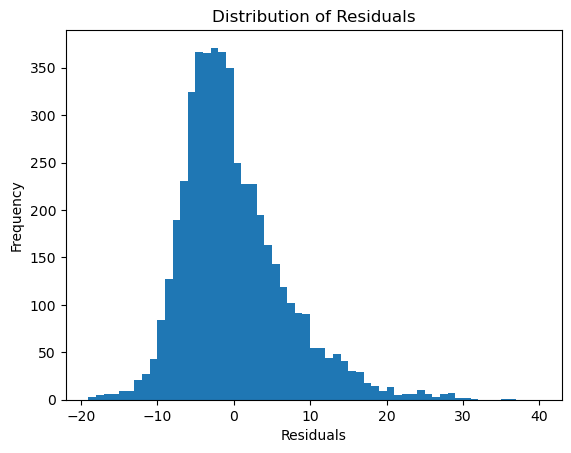

In [53]:

# Berechnen der Residuen für jede Vorhersage und erstellen eines Schaubilds
residuals = y_test - predicted_points

plt.hist(residuals, bins=range(int(np.min(residuals)), int(np.max(residuals)) + 1, 1))
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.savefig('residuals_distribution.pdf', format='pdf')

plt.show()

In [56]:
# Durchführen eines RandomForest

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


predicted_points = model.predict(X_test)


mae = mean_absolute_error(y_test, predicted_points)
print(f"Mean Absolute Error: {mae}")


player_data_2019['predicted_fantasy_points'] = predicted_points


Mean Absolute Error: 1.9426652793094747


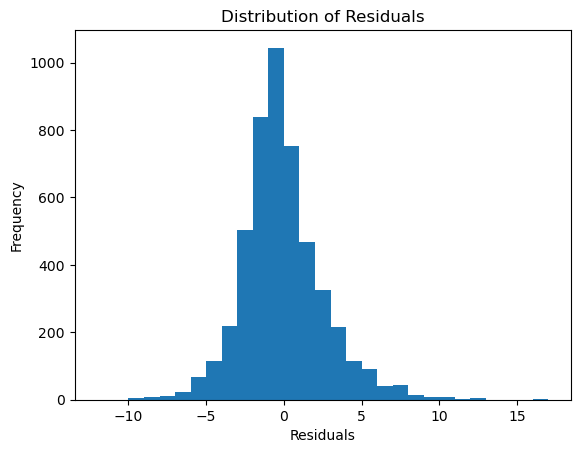

In [57]:
# Berechnen der Residuen für jede Vorhersage und erzeugen eines Schaubilds
residuals = y_test - predicted_points

plt.hist(residuals, bins=range(int(np.min(residuals)), int(np.max(residuals)) + 1, 1))
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.savefig('residuals_distribution_random_forrest.pdf', format='pdf')

plt.show()

In [86]:
# die Daten des ADP-Rankings werden gesraped und verarbeite, so dass jeder Spieler eine player_id hat

url = 'https://www.fantasypros.com/nfl/adp/ppr-overall.php?year=2019'

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', attrs={'id': 'data'})

headers = [header.text for header in table.find_all('th')]

interested_cols = ['Rank', 'Player Team (Bye)', 'POS', 'AVG']

interested_indices = [headers.index(col) for col in interested_cols]

rows = table.find_all('tr')
table_data = []

for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    row_data = [cols[index] for index in interested_indices if index < len(cols)]


    if row_data:
        table_data.append(row_data)

df = pd.DataFrame(table_data, columns=interested_cols)

df['Sleeper'] = np.nan 

team_abbrs = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 
              'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 
              'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 
              'SEA', 'SF', 'TB', 'TEN', 'WAS', 'II', 'Jr.' ,'DST']

# wir erstellen eine Funktion, um die kompletten Namen aus einer Spalte zu extrahieren
def extract_info(row):
    player = row
    team = None
    bye = None


    if '(' in row and ')' in row:
        bye = row[row.index('(')+1:row.index(')')]
        player = row[:row.index('(')].strip()


    last_word = player.split(' ')[-1]
    if last_word in team_abbrs:
        team = last_word
        player = ' '.join(player.split(' ')[:-1])

    
    last_word = player.split(' ')[-1]
    if last_word in ["Jr.", "II"]:
        player = ' '.join(player.split(' ')[:-1])

    return player, team, bye

df[['Player', 'Team', 'Bye']] = df['Player Team (Bye)'].apply(extract_info).apply(pd.Series)

df = df.drop(columns=['Player Team (Bye)'])

df = pd.merge(df, player_data[['player_display_name', 'player_id']], left_on='Player', right_on='player_display_name', how='left')

df = df.drop(columns=['player_display_name'])

df = df.drop_duplicates(subset='player_id', keep='first')

print(df)


      Rank    POS    AVG  Sleeper               Player  Team   Bye   player_id
0        1    RB1    1.0      NaN       Saquon Barkley   NYG    11  00-0034844
13       2    RB2    2.5      NaN  Christian McCaffrey    SF     4  00-0033280
29       3    RB3    2.5      NaN         Alvin Kamara    NO     9  00-0033906
43       4    RB4    4.0      NaN      Ezekiel Elliott  None  None  00-0033045
59       5    WR1    5.3      NaN      DeAndre Hopkins  None  None  00-0030564
...    ...    ...    ...      ...                  ...   ...   ...         ...
5977  1037  QB126  945.0      NaN           Colt McCoy   ARI    12  00-0027688
5981  1041  RB258  961.0      NaN         Buddy Howell  None  None  00-0034449
5983  1042  QB127  962.0      NaN         Nick Mullens   MIN    12  00-0033319
5985  1044  RB260  973.0      NaN       Raheem Mostert   MIA     5  00-0031687
6001  1046  TE188  979.0      NaN          Dawson Knox   BUF     6  00-0035689

[546 rows x 8 columns]


In [25]:
# Durchschnittliche vorhergesagte Punkte über die Saison für jeden Spieler
players_season_avg_2018 = player_data_2018.groupby(['player_id', 'player_display_name', 'position_group'])['fantasy_points_ppr'].mean().reset_index()

# Summe der vorhergesagten Punkte über die Saison für jeden Spieler
players_season_sum_2018 = player_data_2018.groupby(['player_id', 'player_display_name', 'position_group'])['fantasy_points_ppr'].sum().reset_index()

players_season_sum_2018.sort_values('fantasy_points_ppr', ascending=False)

,player_id,player_display_name,position_group,fantasy_points_ppr
505,00-0033873,Patrick Mahomes,QB,417.079987
626,00-0034844,Saquon Barkley,RB,385.799988
437,00-0033280,Christian McCaffrey,RB,385.500000
353,00-0032241,Todd Gurley,RB,372.100006
66,00-0026143,Matt Ryan,QB,354.959991
...,...,...,...,...
77,00-0026625,Brian Hoyer,QB,-0.520000
430,00-0033119,Jacoby Brissett,QB,-0.620000
146,00-0029129,Rod Streater,WR,-1.100000
226,00-0030565,Geno Smith,QB,-1.480000


In [26]:
# Durchschnittliche vorhergesagte Punkte über die Saison für jeden Spieler
players_season_avg_2019 = player_data_2019.groupby(['player_id', 'player_display_name', 'position_group'])['predicted_fantasy_points'].mean().reset_index()

# Summe der vorhergesagten Punkte über die Saison für jeden Spieler
players_season_sum_2019 = player_data_2019.groupby(['player_id', 'player_display_name', 'position_group'])['predicted_fantasy_points'].sum().reset_index()

players_season_sum_2019.sort_values('predicted_fantasy_points', ascending=False)

,player_id,player_display_name,position_group,predicted_fantasy_points
308,00-0033280,Christian McCaffrey,RB,466.998201
431,00-0034796,Lamar Jackson,QB,408.572395
273,00-0032765,Michael Thomas,WR,360.072999
296,00-0033077,Dak Prescott,QB,346.118200
109,00-0029263,Russell Wilson,QB,318.196202
...,...,...,...,...
327,00-0033526,Samaje Perine,RB,1.822000
434,00-0034808,John Kelly,RB,1.768000
363,00-0033911,Taywan Taylor,WR,1.570000
79,00-0027925,James Develin,RB,1.564000


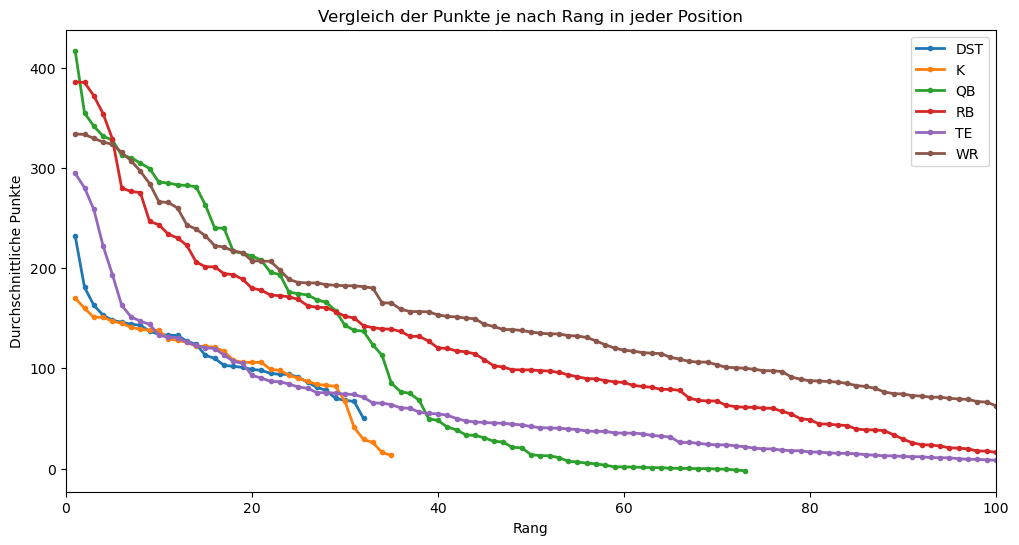

In [66]:
# den Verlauf der Punkte nach Rangliste jeder Position wird gebildet und in einem Schaubild dargestellt.

df = players_season_sum_2018

df = df.dropna()

df = df.sort_values('fantasy_points_ppr', ascending=False)

df['rank'] = df.groupby('position_group')['fantasy_points_ppr'].rank(ascending=False, method='first')

pivot_df = df.pivot_table(values='fantasy_points_ppr', index='rank', columns='position_group')

plt.figure(figsize=(12, 6))
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], marker='.', linewidth=2, label=column)

plt.legend()
plt.title('Vergleich der Punkte je nach Rang in jeder Position')
plt.xlabel('Rang')
plt.ylabel('Durchschnittliche Punkte')

plt.xlim(0, 100)

plt.savefig("line_plot.pdf", format='pdf')

plt.show()

In [98]:
# dies für Variante 1 des Rankings ausführen
# die Daten des ADP-Rankings werden gesraped und verarbeite, so dass jeder Spieler eine player_id hat

url = 'https://www.fantasypros.com/nfl/adp/ppr-overall.php?year=2019'

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', attrs={'id': 'data'})

headers = [header.text for header in table.find_all('th')]

interested_cols = ['Rank', 'Player Team (Bye)', 'POS', 'AVG']

interested_indices = [headers.index(col) for col in interested_cols]

rows = table.find_all('tr')
table_data = []

for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    row_data = [cols[index] for index in interested_indices if index < len(cols)]


    if row_data:
        table_data.append(row_data)

df = pd.DataFrame(table_data, columns=interested_cols)

df['Sleeper'] = np.nan 

team_abbrs = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 
              'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 
              'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 
              'SEA', 'SF', 'TB', 'TEN', 'WAS', 'II', 'Jr.' ,'DST']

# wir erstellen eine Funktion, um die kompletten Namen aus einer Spalte zu extrahieren
def extract_info(row):
    player = row
    team = None
    bye = None


    if '(' in row and ')' in row:
        bye = row[row.index('(')+1:row.index(')')]
        player = row[:row.index('(')].strip()


    last_word = player.split(' ')[-1]
    if last_word in team_abbrs:
        team = last_word
        player = ' '.join(player.split(' ')[:-1])

    
    last_word = player.split(' ')[-1]
    if last_word in ["Jr.", "II"]:
        player = ' '.join(player.split(' ')[:-1])

    return player, team, bye

df[['Player', 'Team', 'Bye']] = df['Player Team (Bye)'].apply(extract_info).apply(pd.Series)

df = df.drop(columns=['Player Team (Bye)'])

df = pd.merge(df, player_data[['player_display_name', 'player_id']], left_on='Player', right_on='player_display_name', how='left')

df = df.drop(columns=['player_display_name'])

df = df.drop_duplicates(subset='player_id', keep='first')


# Sortiere die Saison-Punkte nach Punkten innerhalb der Position
players = players_season_avg_2019.sort_values(by=['position_group', 'predicted_fantasy_points'], ascending=[True, False])

# Berechne die Opportunitätskosten innerhalb der Position
players['opportunity_cost'] = players.groupby('position_group')['predicted_fantasy_points'].diff(-1).abs()


players['opportunity_cost'].fillna(0, inplace=True)

# Gewichtung
weights = {'QB': {'predicted_fantasy_points': 0.5, 'opportunity_cost': 0.5},
           'RB': {'predicted_fantasy_points': 0.5, 'opportunity_cost': 0.5},
           'WR': {'predicted_fantasy_points': 0.5, 'opportunity_cost': 0.5},
           'TE': {'predicted_fantasy_points': 0.5, 'opportunity_cost': 0.5},
           'K': {'predicted_fantasy_points': 0.5, 'opportunity_cost': 0.5},
           'DST': {'predicted_fantasy_points': 0.5, 'opportunity_cost': 0.5}
          }

# Berechne mit den beiden Faktoren den final_score
players['final_score'] = players.apply(lambda row: row['predicted_fantasy_points']*weights[row['position_group']]['predicted_fantasy_points'] 
                                       + row['opportunity_cost']*weights[row['position_group']]['opportunity_cost'], axis=1)

# Sortiere nach final_score
players = players.sort_values('final_score', ascending=False)
# Schreibe den Spielen einen Rang anahnd der Sortierung an
players['rank'] = players['final_score'].rank(ascending=False, method='min')

players_rank = players
players_rank

players_rank['rank'] = players_rank['rank'].astype(float)

# Zusammenführen mit dem ADP-Rannking
merged_df = pd.merge(df, players_rank, on='player_id')

merged_df['AVG'] = merged_df['AVG'].astype(float)


# Berechnen des Durchschnittsrangs
merged_df['average_rank'] = merged_df[['rank', 'AVG']].mean(axis=1)

print(merged_df)

     Rank    POS    AVG  Sleeper               Player  Team   Bye   player_id  \
0       1    RB1    1.0      NaN       Saquon Barkley   NYG    11  00-0034844   
1       2    RB2    2.5      NaN  Christian McCaffrey    SF     4  00-0033280   
2       3    RB3    2.5      NaN         Alvin Kamara    NO     9  00-0033906   
3       4    RB4    4.0      NaN      Ezekiel Elliott  None  None  00-0033045   
4       5    WR1    5.3      NaN      DeAndre Hopkins  None  None  00-0030564   
..    ...    ...    ...      ...                  ...   ...   ...         ...   
397  1035  QB125  936.0      NaN          Josh McCown  None  None  00-0021206   
398  1036  WR374  944.0      NaN          Allen Hurns  None  None  00-0030821   
399  1037  QB126  945.0      NaN           Colt McCoy   ARI    12  00-0027688   
400  1042  QB127  962.0      NaN         Nick Mullens   MIN    12  00-0033319   
401  1044  RB260  973.0      NaN       Raheem Mostert   MIA     5  00-0031687   

     player_display_name po

In [108]:
# Durchführen für Ranking Variante 2

# die Daten des ADP-Rankings werden gesraped und verarbeite, so dass jeder Spieler eine player_id hat

url = 'https://www.fantasypros.com/nfl/adp/ppr-overall.php?year=2019'

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', attrs={'id': 'data'})

headers = [header.text for header in table.find_all('th')]

interested_cols = ['Rank', 'Player Team (Bye)', 'POS', 'AVG']

interested_indices = [headers.index(col) for col in interested_cols]

rows = table.find_all('tr')
table_data = []

for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    row_data = [cols[index] for index in interested_indices if index < len(cols)]


    if row_data:
        table_data.append(row_data)

df = pd.DataFrame(table_data, columns=interested_cols)

df['Sleeper'] = np.nan 

team_abbrs = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 
              'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 
              'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 
              'SEA', 'SF', 'TB', 'TEN', 'WAS', 'II', 'Jr.' ,'DST']

# wir erstellen eine Funktion, um die kompletten Namen aus einer Spalte zu extrahieren
def extract_info(row):
    player = row
    team = None
    bye = None


    if '(' in row and ')' in row:
        bye = row[row.index('(')+1:row.index(')')]
        player = row[:row.index('(')].strip()


    last_word = player.split(' ')[-1]
    if last_word in team_abbrs:
        team = last_word
        player = ' '.join(player.split(' ')[:-1])

    
    last_word = player.split(' ')[-1]
    if last_word in ["Jr.", "II"]:
        player = ' '.join(player.split(' ')[:-1])

    return player, team, bye

df[['Player', 'Team', 'Bye']] = df['Player Team (Bye)'].apply(extract_info).apply(pd.Series)

df = df.drop(columns=['Player Team (Bye)'])

df = pd.merge(df, player_data[['player_display_name', 'player_id']], left_on='Player', right_on='player_display_name', how='left')

df = df.drop(columns=['player_display_name'])

df = df.drop_duplicates(subset='player_id', keep='first')
# Durchschnittliche vorhergesagte Punkte über die Saison für jeden Spieler
players_season_avg_2019 = player_data_2019.groupby(['player_id', 'player_display_name', 'position_group'])['predicted_fantasy_points'].mean().reset_index()

# Summe der vorhergesagten Punkte über die Saison für jeden Spieler
players_season_sum_2019 = player_data_2019.groupby(['player_id', 'player_display_name', 'position_group'])['predicted_fantasy_points'].sum().reset_index()

players_season_sum_2019.sort_values('predicted_fantasy_points', ascending=False)

players_rank = players_season_sum_2019


df = df.merge(players_rank[['player_id', 'predicted_fantasy_points', 'position_group']], on='player_id', how='left')

df = df.dropna(subset=['predicted_fantasy_points', 'position_group'])

players_rank = df
players_rank['AVG'] = players_rank['AVG'].astype(float)

players = players_rank.sort_values(by=['position_group', 'predicted_fantasy_points'], ascending=[True, False])
# der Cutoff-Punkt für die Durchführung des VOR-Modells wird auf 100 gesetzt
adp_cutoff = 100
# Füge den 'replacement_value' für jeden Spieler hinzu
def calculate_replacement_value(row):
    if row['position_group'] in replacement_players.index:
        return replacement_players.loc[row['position_group'], 'predicted_fantasy_points']
    else:
        return 0  


drafted_players = players[players['AVG'] <= adp_cutoff]

# Finden Sie den letzten ausgewählten Spieler für jede Position
replacement_players = drafted_players.groupby('position_group').last()
players['replacement_value'] = players.apply(calculate_replacement_value, axis=1)

# Berechnene den 'VOR' für jeden Spieler
players['vor'] = players['predicted_fantasy_points'] - players['replacement_value']

# Sortieren nach VOR
players = players.sort_values('vor', ascending=False)

# Erstelle eine neue Spalte 'rank', die den Rang des Spielers basierend auf dem VOR repräsentiert
players['rank'] = players['vor'].rank(ascending=False, method='min')

players_rank = players
players_rank['rank'] = players_rank['rank'].astype(float)
# Zusammenführen mit dem ADP-Rannking
merged_df = pd.merge(df, players_rank, on='player_id')

merged_df['AVG'] = merged_df['AVG_x'].astype(float)


# Berechnen des Durchschnittsrangs
merged_df['average_rank'] = merged_df[['rank', 'AVG']].mean(axis=1)

print(merged_df)


    Rank_x  POS_x  AVG_x  Sleeper_x             Player_x Team_x Bye_x  \
0        1    RB1    1.0        NaN       Saquon Barkley    NYG    11   
1        2    RB2    2.5        NaN  Christian McCaffrey     SF     4   
2        3    RB3    2.5        NaN         Alvin Kamara     NO     9   
3        4    RB4    4.0        NaN      Ezekiel Elliott   None  None   
4        5    WR1    5.3        NaN      DeAndre Hopkins   None  None   
..     ...    ...    ...        ...                  ...    ...   ...   
397   1035  QB125  936.0        NaN          Josh McCown   None  None   
398   1036  WR374  944.0        NaN          Allen Hurns   None  None   
399   1037  QB126  945.0        NaN           Colt McCoy    ARI    12   
400   1042  QB127  962.0        NaN         Nick Mullens    MIN    12   
401   1044  RB260  973.0        NaN       Raheem Mostert    MIA     5   

      player_id  predicted_fantasy_points_x position_group_x  ...  \
0    00-0034844                  236.191600           

In [100]:
# Durchführen für Ranking Variante 3
# dem AVG-Ranking werden die vorrausgessagten Punkte angehängt und dann wird das VOR-Modell ausgeführt
players_rank = players_season_sum_2019.copy()


players_rank['rank'] = players_rank['predicted_fantasy_points'].rank(ascending=False, method='min')

players_rank

players_rank = df
players_rank['AVG'] = players_rank['AVG'].astype(float)

players = players_rank.sort_values(by=['position_group', 'predicted_fantasy_points'], ascending=[True, False])
# der Cutoff-Punkt für die Durchführung des VOR-Modells wird auf 100 gesetzt
adp_cutoff = 100
# Füge den 'replacement_value' für jeden Spieler hinzu
def calculate_replacement_value(row):
    if row['position_group'] in replacement_players.index:
        return replacement_players.loc[row['position_group'], 'predicted_fantasy_points']
    else:
        return 0  


drafted_players = players[players['AVG'] <= adp_cutoff]

# Finden Sie den letzten ausgewählten Spieler für jede Position
replacement_players = drafted_players.groupby('position_group').last()
players['replacement_value'] = players.apply(calculate_replacement_value, axis=1)

# Berechnene den 'VOR' für jeden Spieler
players['vor'] = players['predicted_fantasy_points'] - players['replacement_value']

# Sortieren nach VOR
players = players.sort_values('vor', ascending=False)

# Erstelle eine neue Spalte 'rank', die den Rang des Spielers basierend auf dem VOR repräsentiert
players['rank'] = players['vor'].rank(ascending=False, method='min')

players_rank = players


In [33]:
# Erstelle ein csv für Variante 3 
players_rank.to_csv('rank.csv')

In [131]:
# Erstelle ein csv für Variante 1 oder 2
merged_df.to_csv('rank.csv')

In [132]:
# Erstelle ein csv für die Spielerdaten mit vorrausgesagten Punkten
player_data_2019.to_csv('player_data.csv')

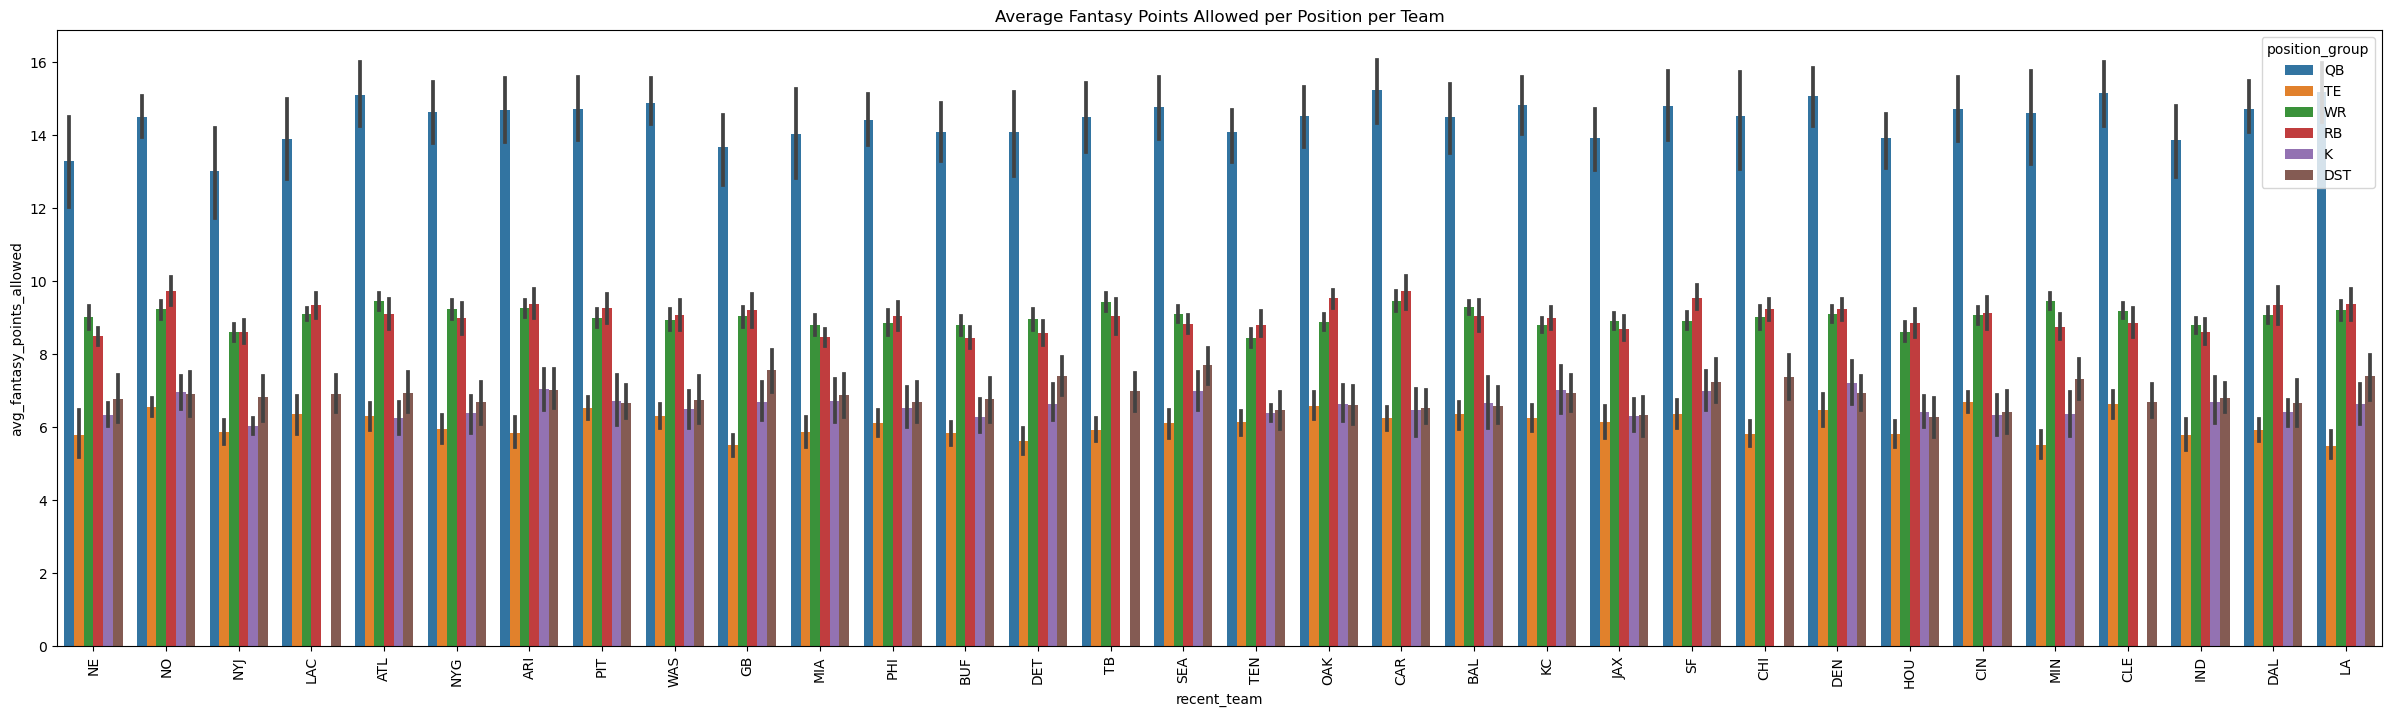

In [56]:
plt.figure(figsize=(30,8))
sns.barplot(x='recent_team', y='avg_fantasy_points_allowed', hue='position_group', data=player_data_1)
plt.xticks(rotation=90)
plt.title('Average Fantasy Points Allowed per Position per Team')
plt.show()

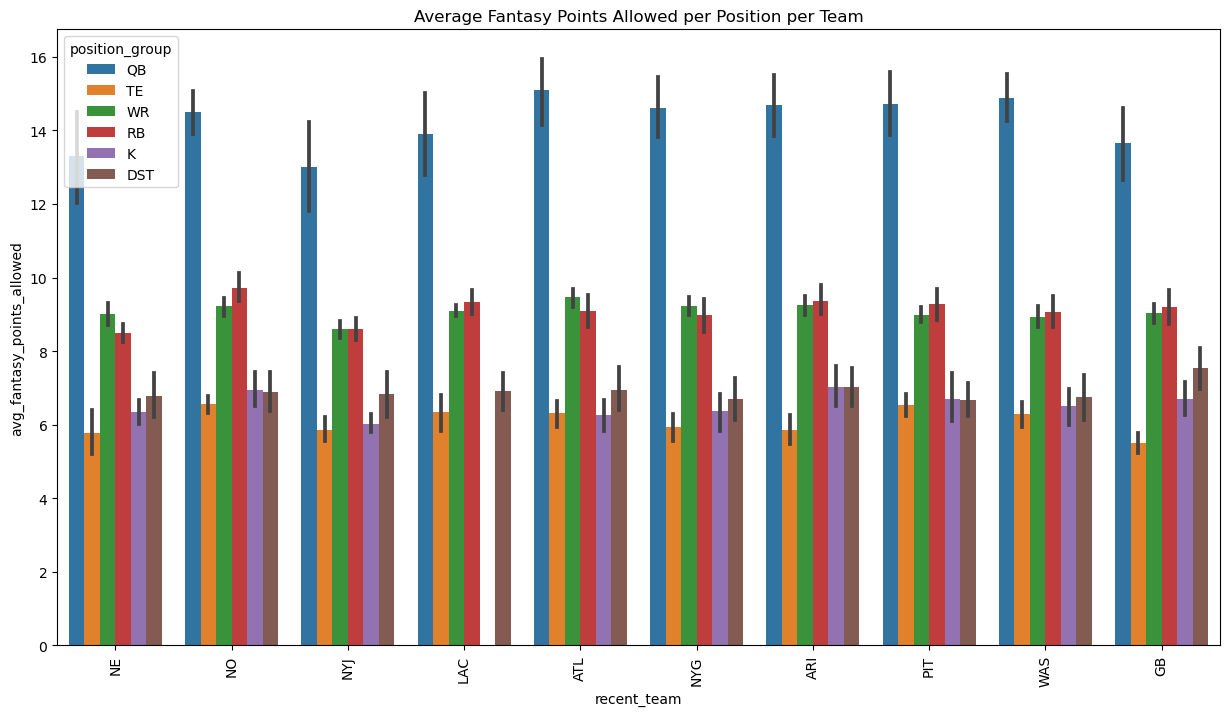

In [178]:
# Darstellung von zugelassenen Punkten für 10 Teams, damit ich das Schaubild in Arbeit verwenden kann
top_10_teams = player_data_1['recent_team'].unique()[:10]

filtered_data = player_data_1[player_data_1['recent_team'].isin(top_10_teams)]

plt.figure(figsize=(15,8))
sns.barplot(x='recent_team', y='avg_fantasy_points_allowed', hue='position_group', data=filtered_data)
plt.xticks(rotation=90)
plt.title('Average Fantasy Points Allowed per Position per Team')
plt.savefig("allowed_points.pdf", format='pdf')
plt.show()

